# Dogs 분류

In [52]:
# 패키지 불러오기
import sys, warnings
# sys.path.append("Y:\Python\Mega_IT")
warnings.filterwarnings('ignore')

# from yjk_module.preprocessing import *
# from yjk_module.ml_module import *
# from yjk_module.dl_module import *

# import os
# os.chdir("Y:\Python\Mega_IT\H.Deep_Learning")
# os.getcwd()

# from hossam.util import *
# from hossam.plot import *
# from hossam.tensor import *
# from hossam.classification import *
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop, Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback, History

from kerastuner import Hyperband
from datetime import datetime as dt

In [3]:
# 데이터 불러오기
origin1 = pd.read_excel('./data/dogs.xlsx')
origin1.head()

,dog,length,height
0,d,55.01,29.27
1,d,59.01,29.39
2,d,56.53,28.50
3,d,53.66,28.50
4,d,49.67,31.97


In [6]:
# 종속변수 라벨링
# df = my_labelling(origin1, 'dog')

df = origin1.copy()
le = LabelEncoder()
df['dog'] = le.fit_transform(df['dog'])
df.head()

,dog,length,height
0,0,55.01,29.27
1,0,59.01,29.39
2,0,56.53,28.50
3,0,53.66,28.50
4,0,49.67,31.97


In [8]:
# 훈련 / 검증 데이터 분리
# x_train, x_test, y_train, y_test = my_train_test_split(data=df1, yname='dog')

X = df.copy()
Y = X.pop('dog')

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((160, 2), (40, 2), (160,), (40,))

In [9]:
# 모델 구성 및 컴파일
model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(x_train.shape[1], )))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                96        
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 129 (516.00 Byte)
Trainable params: 129 (516.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


2024-04-24 16:40:38.734463: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22433 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:08:00.0, compute capability: 8.6


In [10]:
%%time

# 모델 훈련

result = model.fit(x_train, y_train, epochs = 500, validation_data = (x_test, y_test), verbose=0, callbacks = [
    EarlyStopping(monitor = 'val_acc', patience=10, verbose = 0),
    ReduceLROnPlateau(monitor= "val_acc", patience=5, min_lr=0.0001, verbose=0)
])

2024-04-24 16:40:51.199670: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0cbaf99940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-04-24 16:40:51.199686: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2024-04-24 16:40:51.202835: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-04-24 16:40:51.209673: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1713944451.233193   41258 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


CPU times: user 988 ms, sys: 55.9 ms, total: 1.04 s
Wall time: 1.1 s


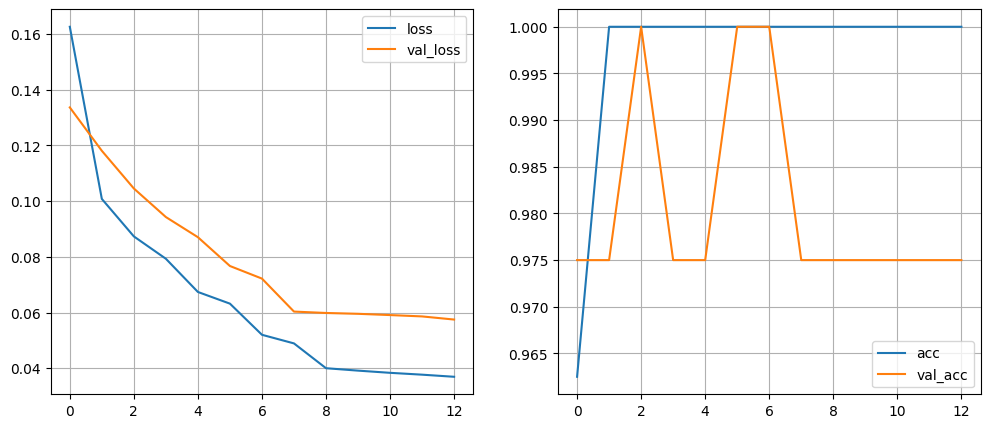

In [11]:
# 학습 곡선 확인
# tf_result(result, history_table=True)

hist_dict = result.history
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(hist_dict['loss'], label = 'loss')
ax[0].plot(hist_dict['val_loss'], label = 'val_loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(hist_dict['acc'], label = 'acc')
ax[1].plot(hist_dict['val_acc'], label = 'val_acc')
ax[1].grid()
ax[1].legend()

plt.show()

In [13]:
# 검증 데이터에 대한 예측
test_pred = model.predict(x_test)
data_count, case_count = test_pred.shape
print("%d개의 검증 데이터가 %d개의 경우의 수를 갖는다." % (data_count, case_count))
print(test_pred[:5])

2/2 [==============================] - 0s 1ms/step
40개의 검증 데이터가 1개의 경우의 수를 갖는다.
[[0.09668845]
 [0.99018127]
 [0.9917161 ]
 [0.02706456]
 [0.94505495]]


In [14]:
pred = test_pred.flatten()
pred

array([9.66884494e-02, 9.90181267e-01, 9.91716087e-01, 2.70645637e-02,
       9.45054948e-01, 9.94106054e-01, 4.64645252e-02, 8.54190767e-01,
       3.66310123e-03, 9.86925244e-01, 2.18818337e-02, 9.95864272e-01,
       9.96304393e-01, 9.97049034e-01, 5.46824448e-02, 1.70685425e-02,
       8.64631729e-04, 9.77537811e-01, 4.85562719e-02, 8.40509385e-02,
       9.81245995e-01, 9.86796379e-01, 1.03421226e-01, 9.83098567e-01,
       5.56586450e-03, 7.71378398e-01, 9.61003125e-01, 9.61597264e-01,
       9.94199038e-01, 8.25622771e-03, 1.05605669e-01, 1.11345490e-02,
       9.76457417e-01, 9.90841985e-01, 9.45353694e-03, 9.89100993e-01,
       9.89221692e-01, 8.33054483e-02, 5.34690499e-01, 9.56567049e-01],
      dtype=float32)

In [16]:
# Keras-tuner 사용을 위한 모델 객체 반환 함수 생성
# 파라미터 : hp.Choice(하이퍼파라미터 별명 지정, values = [Search 할 값들])

def model_create(hp):
    model = Sequential([
        Dense(hp.Choice('units1', values = [128, 64, 32]), activation = 'relu', input_shape = (x_train.shape[1],)),
        Dropout(hp.Choice('dropout1', values = [0.1, 0.15, 0.2])),
        Dense(hp.Choice('units2', values = [64, 32, 16]), activation = 'relu'),
        Dropout(hp.Choice('dropout2', values = [0.1, 0.15, 0.2])),
        Dense(1, activation = 'sigmoid')
    ])

    model.compile(optimizer = hp.Choice('optimizer', values = ['adam', 'rmsprop', 'nadam']), loss = 'binary_crossentropy', metrics = 'acc')
    return model

In [17]:
# Hyperband 객체 생성 및 함수 입력
tuner = Hyperband(
    hypermodel=model_create,
    objective="val_acc",
    max_epochs=10,
    factor=3,
    seed=0,
    directory="./tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [18]:
%%time

# Hyperband를 사용한 적합 하이퍼파라미터 찾기

tuner.search(
    x_train, y_train, epochs=300, batch_size=32, validation_data=(x_test, y_test), verbose = 0
)

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters()

if not best_hps:
    raise ValueError("No best hyperparameters found.")

CPU times: user 27.4 s, sys: 748 ms, total: 28.2 s
Wall time: 29.3 s


# 타이타닉 분류

In [19]:
# 데이터 불러오기
origin2 = pd.read_excel("./data/titanic.xlsx")
origin2.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [34]:
# 불필요 컬럼 제거
df2 = origin2.drop(['Name', 'Ticket', 'Cabin', 'PassengerId'], axis = 1)
df2['Pclass'] = df2['Pclass'].astype('category')
df2.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [35]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  1309 non-null   int64   
 1   Pclass    1309 non-null   category
 2   Sex       1309 non-null   object  
 3   Age       1046 non-null   float64 
 4   SibSp     1309 non-null   int64   
 5   Parch     1309 non-null   int64   
 6   Fare      1308 non-null   float64 
 7   Embarked  1307 non-null   object  
dtypes: category(1), float64(2), int64(3), object(2)
memory usage: 73.1+ KB


In [36]:
# 데이터 전처리 수행
# pp = YjkPreprocessor()
# pp.set_strategy(outline = None, null = 'median')
# df2_p = pp.fit_transform(df2, yname = 'Survived')

Y = df2.pop('Survived')

cols_n = df2.select_dtypes('number').columns
cols_o = df2.select_dtypes('object').columns

for i in cols_n:
    df2[i] = df2[i].fillna(df2[i].median())
for i in cols_o:
    df2[i] = df2[i].fillna(df2[i].mode()[0])

ss = StandardScaler()
df2[cols_n] = ss.fit_transform(df2[cols_n])

oh = OneHotEncoder(sparse_output = False)
df2_oh = pd.DataFrame(oh.fit_transform(df2[cols_o]), columns = oh.get_feature_names_out())

df2_p = pd.concat([df2[cols_n], df2_oh], axis = 1)
df2_p.head()

,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,-0.581628,0.481288,-0.445,-0.503291,0.0,1.0,0.0,0.0,1.0
1,0.658652,0.481288,-0.445,0.734744,1.0,0.0,1.0,0.0,0.0
2,-0.271558,-0.479087,-0.445,-0.490240,1.0,0.0,0.0,0.0,1.0
3,0.426099,0.481288,-0.445,0.383183,1.0,0.0,0.0,0.0,1.0
4,0.426099,-0.479087,-0.445,-0.487824,0.0,1.0,0.0,0.0,1.0


In [37]:
# 훈련 / 검증 데이터 분리
# x_train, x_test, y_train, y_test = my_train_test_split(df2_p, yname = 'Survived', test_size = 0.2)

x_train, x_test, y_train, y_test = train_test_split(df2_p, Y, test_size = 0.2, random_state = 0)

In [38]:
# 모델 생성 및 훈련
# model = my_tf(
#     x_train=x_train,
#     y_train=y_train,
#     x_test=x_test,
#     y_test=y_test,
#     dense= [
#         {"units": 32, "activation": "relu", "input_shape": (x_train.shape[1], )},
#         {"units": 1, "activation": "sigmoid"}
#     ],
#     optimizer="rmsprop",
#     loss="binary_crossentropy",
#     metrics=["acc"]
# )

# my_classification_result(model, x_train, y_train, x_test, y_test)
# my_classification_report(model, x_train, y_train, x_test, y_test)


model2 = Sequential([
    Dense(32, activation = 'relu', input_shape = (x_train.shape[1],)),
    Dense(1, activation = 'sigmoid')
])

model2.compile(optimizer = 'rmsprop', loss = 'binary_crossentropy', metrics = ['acc'])
history2 = model2.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 1000, callbacks = [
    EarlyStopping(patience = 8, restore_best_weights = True)
])

Epoch 1/1000
33/33 [==============================] - 0s 5ms/step - loss: 0.6039 - acc: 0.7459 - val_loss: 0.5623 - val_acc: 0.7672
Epoch 2/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.5249 - acc: 0.7975 - val_loss: 0.5028 - val_acc: 0.8550
Epoch 3/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.4779 - acc: 0.8481 - val_loss: 0.4563 - val_acc: 0.8664
Epoch 4/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.4460 - acc: 0.8520 - val_loss: 0.4225 - val_acc: 0.8588
Epoch 5/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.4238 - acc: 0.8520 - val_loss: 0.3978 - val_acc: 0.8588
Epoch 6/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.4089 - acc: 0.8510 - val_loss: 0.3797 - val_acc: 0.8588
Epoch 7/1000
33/33 [==============================] - 0s 3ms/step - loss: 0.3998 - acc: 0.8510 - val_loss: 0.3687 - val_acc: 0.8626
Epoch 8/1000
33/33 [==============================] - 0s 2ms/step - loss: 0.

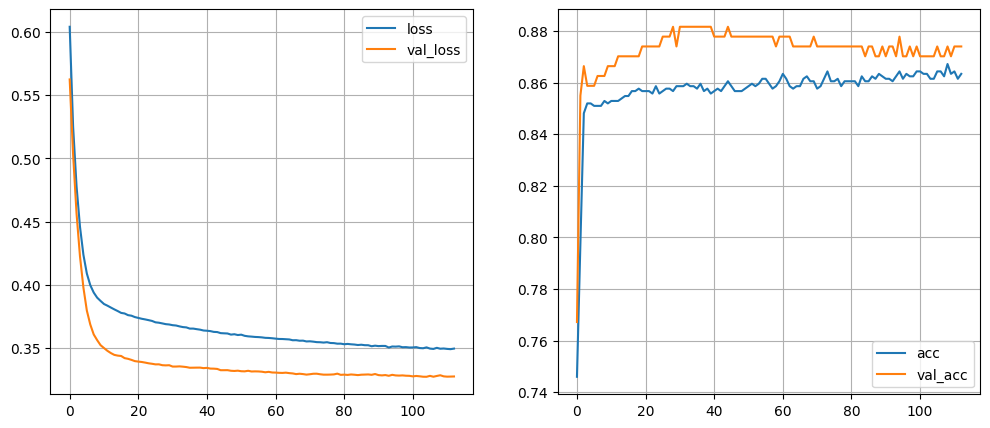

In [39]:
# 학습곡선 확인
hist_dict = history2.history
fig, ax = plt.subplots(1, 2, figsize = (12, 5))

ax[0].plot(hist_dict['loss'], label = 'loss')
ax[0].plot(hist_dict['val_loss'], label = 'val_loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(hist_dict['acc'], label = 'acc')
ax[1].plot(hist_dict['val_acc'], label = 'val_acc')
ax[1].grid()
ax[1].legend()

plt.show()

9/9 [==============================] - 0s 660us/step


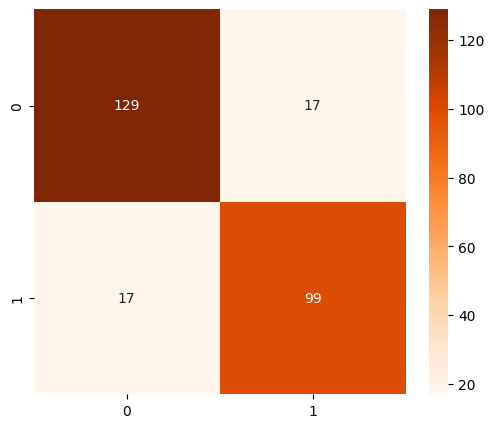

In [53]:
# 검증데이터에 대한 혼동행렬 확인
pred2 = model2.predict(x_test)
pred2 = list(np.where(pred2 > 0.5, 1, 0).flatten())
pred2

c_mat = confusion_matrix(y_test, pred2)

plt.figure(figsize = (6, 5))
sns.heatmap(c_mat, annot = True, fmt = 'd', cmap = 'Oranges')
plt.show()

In [54]:
# keras-tuner 객체 생성
tuner2 = Hyperband(
    hypermodel=model_create,
    objective="val_acc",
    max_epochs=100,
    factor=3,
    seed=0,
    directory="./tensor_hyperband",
    project_name="tf_hyperband_%s" % dt.now().strftime("%Y%m%d%H%M%S"),
)

tuner

In [55]:
%%time

# 하이퍼파라미터 찾기
tuner2.search(
    x_train, y_train, epochs=300, batch_size=32, validation_data=(x_test, y_test), verbose = 0
)

# Get the optimal hyperparameters
best_hps2 = tuner2.get_best_hyperparameters()

if not best_hps2:
    raise ValueError("No best hyperparameters found.")

CPU times: user 10min 55s, sys: 21.8 s, total: 11min 17s
Wall time: 9min 55s


In [56]:
best_hps2